In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Device is {device}.")

Device is cuda.


Transform our data by converting greyscale to RGB, resizing to 224 x 224, and converting to tensors.

In [3]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [4]:
from torchvision import transforms
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [5]:
# Reading train data
train_dir = '/content/drive/MyDrive/cards/train'
print(f'will read train data from; {train_dir}')

will read train data from; /content/drive/MyDrive/cards/train


In [6]:
# loading dataset using train directory
from torchvision import datasets
dataset = datasets.ImageFolder(train_dir, transform=transform)

In [7]:
# classes of this dataset
print('list of classes in dataset:',dataset.classes)
# Length of dataset classes
print('legth of dataset classes is ',len(dataset.classes))
# shape of a single image
print(dataset[0][0].shape)

list of classes in dataset: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
legth of data

Batching the dataset using `DataLoader`, with a batch size of 32

In [8]:
from torch.utils.data import DataLoader
batch_size = 32
Loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [9]:
# Inspecting a batch
batch1 = next(iter(Loader))

print('shape of one batch', batch1[0].shape)
print('shape of labels', batch1[1].shape)

shape of one batch torch.Size([32, 3, 224, 224])
shape of labels torch.Size([32])


In [10]:
# Computing mean and std of the data
sum_, sum_sq, count = 0, 0, 0
for i, (data, _) in enumerate(Loader):
    if i == 100: break
    batch_size, channels, height, width = data.shape
    data = data.view(batch_size, channels, -1)
    sum_ += data.sum(dim=[0, 2])
    sum_sq += (data ** 2).sum(dim=[0, 2])
    count += batch_size * height * width

mean = sum_ / count
std = (sum_sq / count - mean ** 2).sqrt()

In [11]:
# Values
print('mean: ',mean)
print('std: ',std)

mean:  tensor([0.7797, 0.7317, 0.7068])
std:  tensor([0.3050, 0.3353, 0.3410])


In [12]:
mean = [0.7750, 0.7294, 0.7010]
std = [0.3087, 0.3369, 0.3432]
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [13]:
# Creating a new Datset and DataLoader with new transformer
dataset_norm = datasets.ImageFolder(train_dir, transform=transform_norm)
loader_norm = DataLoader(dataset_norm, batch_size=batch_size)

In [14]:
# Splittin into train and validation
from torch.utils.data import random_split
g = torch.Generator()
g.manual_seed(26)

train_dataset, val_dataset = random_split(dataset_norm, [0.8, 0.2], generator=g)

len_train = len(train_dataset) / len(dataset_norm)
len_val = len(val_dataset) / len(dataset_norm)
print(f'length of train dataset is {len_train*100:.0f}%')
print(f'length of train dataset is {len_val*100:.0f}%')

length of train dataset is 80%
length of train dataset is 20%


In [15]:
from tqdm.notebook import tqdm
import pandas as pd
# Examining class distriution
from collections import Counter
def class_dist(dataset):
    counter = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: counter[idx] for cat, idx in class_to_index.items()})

In [16]:
train_distribution = class_dist(train_dataset)

train_distribution

  0%|          | 0/6103 [00:00<?, ?it/s]

,0
ace of clubs,104
ace of diamonds,105
ace of hearts,142
ace of spades,150
eight of clubs,120
eight of diamonds,124
eight of hearts,118
eight of spades,109
five of clubs,123
five of diamonds,116


The dataset exhibits a mild to moderate class imbalance. The most represented class has 140 samples (ace of spades), while the least represented has 77 samples (four of diamonds). This gives a class imbalance ratio of 1.8, which is not extreme and is generally manageable in deep learning workflows.

In [17]:
val_distribution = class_dist(val_dataset)
val_distribution

  0%|          | 0/1525 [00:00<?, ?it/s]

,0
ace of clubs,16
ace of diamonds,24
ace of hearts,29
ace of spades,31
eight of clubs,18
eight of diamonds,35
eight of hearts,34
eight of spades,26
five of clubs,27
five of diamonds,22


In [18]:
g = torch.Generator()
g.manual_seed(42)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

# The Model

## Network Architecture

In [19]:
import torch
model = torch.nn.Sequential()

# Layer 1
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model.append(conv1)
model.append(torch.nn.ReLU())
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(max_pool1)

# Layer 2
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1) # takes in the 16 channels from the previous layer and outputs 32 channels
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

# Layer 3
conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

# Layer 4
conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
max_pool4 = torch.nn.MaxPool2d(2)
model.append(conv4)
model.append(torch.nn.ReLU())
model.append(max_pool4)
# An output layer with 53 neurons is needed. That's a flat output, without the 3D structure of our images. PyTorch provides a Flatten layer for flattening.
model.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
)

A single layer could be added and just go straight to the output of 53 classes. However, a better performance can be gotten by adding a few dense layers, Linear, in PyTorch's terminology, first. For these layers, the size of the input has to be defined, and how many neurons we want in the layer.

In [20]:
input, _ = next(iter(train_loader))

with torch.no_grad():
    output = model(input)

output.shape

torch.Size([32, 25088])

In [21]:
linear1 = torch.nn.Linear(in_features=25088, out_features=2048)
linear2 = torch.nn.Linear(in_features=2048, out_features=512)
output_layer = torch.nn.Linear(in_features=512, out_features=53)

model.append(linear1)
model.append(torch.nn.ReLU())
model.append(linear2)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout(0.5))
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=25088, out_features=2048, bias=True)
  (14): ReLU()
  (15): Linear(in_features=2048, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=53, bias=True)
)

In [22]:
# Final check
input, _ = next(iter(train_loader))

with torch.no_grad():
    output = model(input)

output.shape

torch.Size([32, 53])

In [24]:
# To Make sure the model is correct, we use Pytorch's summary
from torchinfo import summary
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 53]                  --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Conv2d: 1-10                           [32, 128, 28, 28]         73,856
├─ReLU: 1-11                             [32, 128, 28, 28]         --
├─MaxPool2d: 1-12                        [32, 128, 14, 14]         --
├─F

In [25]:
# i'll now define my optimsiser and loss fn
import torch.optim as optim
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=25088, out_features=2048, bias=True)
  (14): ReLU()
  (15): Linear(in_features=2048, out_features=512, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=512, out_features=53, bias=True)
)

## Now to train the model

### Training Function

In [26]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = training_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total * 100

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validating {epoch+1}/{epochs}", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total * 100

        print(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
            f"- Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%"
        )

In [27]:
train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=15)

Training Epoch 1/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 1/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 3.5218 | Train Acc: 10.50% - Val Loss: 2.7128 | Val Acc: 25.64%


Training Epoch 2/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 2/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 2.6099 | Train Acc: 26.90% - Val Loss: 2.3089 | Val Acc: 29.57%


Training Epoch 3/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 3/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 2.3356 | Train Acc: 32.05% - Val Loss: 2.1418 | Val Acc: 34.75%


Training Epoch 4/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 4/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 2.1790 | Train Acc: 34.44% - Val Loss: 2.0663 | Val Acc: 36.33%


Training Epoch 5/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 5/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 2.0552 | Train Acc: 37.34% - Val Loss: 1.9723 | Val Acc: 39.48%


Training Epoch 6/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 6/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 1.9483 | Train Acc: 40.03% - Val Loss: 1.9261 | Val Acc: 42.69%


Training Epoch 7/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 7/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 1.8749 | Train Acc: 42.13% - Val Loss: 1.8687 | Val Acc: 45.05%


Training Epoch 8/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 8/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 1.7808 | Train Acc: 44.78% - Val Loss: 1.8140 | Val Acc: 45.70%


Training Epoch 9/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 9/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 1.6884 | Train Acc: 48.42% - Val Loss: 1.7742 | Val Acc: 46.95%


Training Epoch 10/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 10/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 1.6164 | Train Acc: 50.20% - Val Loss: 1.6936 | Val Acc: 50.56%


Training Epoch 11/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 11/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 1.5273 | Train Acc: 53.27% - Val Loss: 1.6699 | Val Acc: 50.95%


Training Epoch 12/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 12/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 1.4416 | Train Acc: 56.43% - Val Loss: 1.6194 | Val Acc: 52.59%


Training Epoch 13/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 13/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 1.3364 | Train Acc: 59.63% - Val Loss: 1.5099 | Val Acc: 56.52%


Training Epoch 14/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 14/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 1.2677 | Train Acc: 62.58% - Val Loss: 1.5177 | Val Acc: 57.05%


Training Epoch 15/15:   0%|          | 0/191 [00:00<?, ?it/s]

Validating 15/15:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 1.1849 | Train Acc: 64.30% - Val Loss: 1.5035 | Val Acc: 59.02%


### Predict Function

In [28]:
import torch.nn.functional as F
def predict(model, dataloader, device):
    model.eval()
    all_probs = torch.tensor([]).to(device)
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

# Testing The Model

Using an image from the test data to test the model

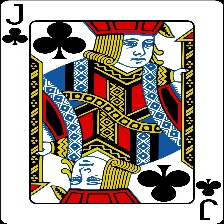

In [29]:
import PIL
img = '/content/drive/MyDrive/cards/test/jack of clubs/5.jpg'
test_image = PIL.Image.open(img)
test_image

The model expects a batch input, so for a single image, an extra dimension will be added to make it 1 x 3 x 224 x 224. unsqueeze(0) does this easily.

In [41]:
# Wrapping it all in a function
from PIL import Image
def classifier(path):
    image = Image.open(path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    predicted_class = conf_df.idxmax(axis=1).item()
    return predicted_class

In [42]:
classification = classifier('/content/drive/MyDrive/cards/test/jack of clubs/5.jpg')

print(f"Predicted class: {classification})")

Predicted class: jack of clubs)


In [44]:
cards = [
    '/content/drive/MyDrive/cards/test/ace of clubs/3.jpg',
    '/content/drive/MyDrive/cards/test/eight of clubs/2.jpg',
    '/content/drive/MyDrive/cards/test/jack of clubs/5.jpg',
    '/content/drive/MyDrive/cards/test/nine of diamonds/4.jpg',
    '/content/drive/MyDrive/cards/test/queen of spades/5.jpg',
    '/content/drive/MyDrive/cards/test/joker/3.jpg',
    '/content/drive/MyDrive/cards/test/six of diamonds/4.jpg'
]

for card in cards:
    classified = classifier(card)
    print(f"Predicted class: {classified}")

Predicted class: ace of clubs
Predicted class: eight of clubs
Predicted class: jack of clubs
Predicted class: nine of diamonds
Predicted class: queen of spades
Predicted class: ace of hearts
Predicted class: six of diamonds


In [33]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/CNN Model.pth')